# Developing hardware with Python

Developing programmable hardware with Python is fun and sustainable. We can create circuits, simulate their behaviour using a virtual scope, or we can connect it to whatever we want, even real hardware, Python being the glue.

## Introduction

Assuming, you have already seen Python, let's start with a simple example:

# Hardware entwickeln mit Python

Hardware mit Hilfe von Python zu entwerfen macht Spass und ist nachhaltig!
Wir können Schaltkreise beschreiben, und deren Verhalten mittels eines virtuellen Oszilloskops simulieren, oder
wir schliessen den virtuellen Schaltkreis an das Python-Ökosystem an, mit Hilfe externer Module sogar an echte Hardware. 

## Einführung

Angenommen, Du hast bereits einmal Python gesehen, ein einfaches Beispiel:

In [1]:
for i in range(5):
    print(i)

0
1
2
3
4


As you would have expected. So this is software: We can tell it to iterate through a certain range, because there's a framework behind it, interpreting commands.

If we wanted to start from scratch and model this as a very simple hardware, we would have to think **in hardware**. So we might ponder what hardware entities are needed to count to 5, likewise (apart from the `print()` statement, which inserted for simulation convenience only).

Now what would be the minimal logic counterpart?

Wie erwartet. Das ist also die Software-Seite: Wir befehlen Python durch einen gewissen Bereich (0..4) zu iterieren (damit offenbart sich die Eigenheit von Python, den angegebenen Stop-Wert des Bereichs nicht mit einzuschliessen).
Das dahinterliegende komplexe Umgebung (PC, Betriebssystem, Python-Interpreter) ist also in der Lage, Befehle auszuführen.

Wenn wir nun ohne diese Umgebung von Null anfangen und diesen Zähler als möglichst einfache Hardware modellieren wollen, müssen wir auch in Hardware denken. D.h. es stellt sich die Frage: Was für Logikprimitiven sind nötig, um einen Zähler zu bauen?

Dabei würde eigentlich auch der `print()`-Befehl wegfallen, da er Teil der Software-Frameworks ist. Wir dürfen ihn allerdings drinlassen, solange wir ihn nicht in Hardware verwandeln, dient er praktisch als Hilfsmittel während der Verifikation.

Was wäre nun das minimale Logik⁻Gegenstück?

In [2]:
from myhdl import *
@block
def counter(clk):
    out = Signal(intbv(0))
    
    @always(clk.posedge)
    def count():
        if out < 4:
            out.next = out + 1
        print(out)
            
    return instances()

If we run the previous, nothing is happening yet. Of course, it's a function which is never called. But what are these `@block` and `always` decorators for?
Well, this is not up to this introduction to explain. If you are new to this, visit [the official MyHDL documentation](http://www.myhdl.org/docs/examples/)

Wenn wir obigen Code per Run laufenlassen, passiert zunächst nichts. Natürlich, es ist eine Funktion, die nicht aufgerufen wird. Aber wofür sind die `@block` und `always` Dekoratoren?
Leider hört unsere grundsätzliche Einführung in diese Python-Mechanismen hier auf. Wenn Du damit komplett neu anfängst, empfiehlt sich die  [offizielle MyHDL-Dokumentation](http://www.myhdl.org/docs/examples/)

## Modeling behaviour

Modelling behaviour is *test driven development*. There is an idea how the circuit should work, so you have to design logic that behaves as you want and according to an external stimulus. This is the real world, like a chip has pins and is driven by signals. For our above `counter` example, the external stimulus is the `clk` signal, expecting an input clock.
To start creating our model, we therefore need to model a clock generator. There's now one important thing to regard: The clock generator is normally an entity living outside the chip, like an oscillator. So -- for now at least -- it is considered a virtual element, it is not synthesized to hardware, a priori. It is part of our virtual hardware: The test bench. We are going to create one now.

## Verhalten modellieren

Verhalten von Hardware zu modellieren orientiert sich am sogenannten *test driven development*, also das gleichzeitige Programmieren eines Gegentests zu den Anforderungen.

Es gibt also eine Idee, wie der Schaltkreis funktionieren muss, also designen wir Logik, die sich entsprechend einer externen Stimulierung verhält. So sieht die reale Welt aus: Ein Chip der Pins besitzt und von elektrischen Signalen getrieben wird. Für unseren Zähler oben, der externe Stimulus ist das Signal `clk`, welches einen Eingangstakt erwartet.

Zu Beginn benötigen wir also erst mal einen Taktgenerator. Damit behalten wir allerdings erst einmal im Hinterkopf: Der Taktgenerator ist normalerweise ein Ding, was ausserhalb unseres virtuellen Chips existiert, z.B. ein Ozillator. Also: Für den Moment behandeln wir ihn als ein virtuelles Element, nicht als Teil unserer später *synthetisierten* Hardware.
Er gehört somit zur *Test Bench*, unserem Teststand, den wir nun wie folgt erstellen.

## Simulation

If we run the next example, we should be somewhat satisfied: We can see that the counter is stuck at `four`, but it is going to be printed out for the following simulation cycles.

**Exercise**: Modify the counter example that the value is no longer printed out when the counter has reached its end value.

## Simulation

Sobald wir das nächste Beispiel laufen lassen, sollte sich eine (begrenzte) Genugtuung einstellen: Der Zähler bleibt bei der `4` stecken und wird für weitere Simulationszyklen weiterhin ausgedruckt. Wir stellen fest: Den Endzustand, dass kein weiterer Wert ausgedruckt werden kann, haben wir in dieser Form nicht codiert. Da aber die `print`-Anweisung sowieso nur für Simulationszwecke gedacht ist, sehen wir von weiterer Komplexität erst einmal ab.

In [3]:
@block
def clkgen(clk_out, DELAY):
    """Clock generator. Toggles the clk_out pin every DELAY cycle -- forever"""
    @instance
    def virtual_worker():
        while 1:
            yield delay(DELAY)
            clk_out.next = not clk_out
    return instances()

@block
def testbench():
    """Our test bench. This integrates the unit under test (UUT) i.e. our counter, plus
the above clock generator. It also defines the clock signal from the top level"""
    clk = Signal(bool(0))
    unit_under_test = counter(clk)
    clock_generator = clkgen(clk, 1)
    
    return instances()


tb = testbench()
tb.config_sim(backend = 'myhdl', timescale="1ns", trace=False)
tb.run_sim(20)
tb.quit_sim()


0
1
2
3
4
4
4
4
4
4


<class 'myhdl._SuspendSimulation'>: Simulated 20 timesteps


## Synthesis

TODO:

* Explain yosys functionality
* Explain a few simple RTL elements

We have modelled a simple stop counter behaviour. Now we would like to synthesize a true hardware element from it, that can be integrated into a chip.
However, our counter has a flaw: it contains a `print` statement which does not make sense on the silicon level. Also, nothing is done with the `out` value, as it's remaining inside the logic. So, we're going to pull the `out` signal out of the design and give it a defined bit width in the process -- which is important for synthesis.
As we're counting up to four, three bits will suffice.

## Synthese

Noch zu erledigen:

* Prinzipielle Funktion von Yosys
* Einige RTL-Elemente erklären

Wir haben bisher einen einfachen Stopzähler modelliert. Jetzt würden wir gerne ein echtes Hardware-Element daraus erzeugen, was im Prinzip auf einem Chip integriert werden kann.
Allerdings hat unser Zähler einen Makel: Er beinhaltet noch den `print`-Befehl, der auf der Silizium-Ebene als solches nicht definiert ist. Ebenso wird der `out`-Wert nicht weiter verwendet, da er nur innerhalb der beschriebenen Logik existiert. Wir werden also das `out`-Signal nach aussen verdrahten und eine explizite Bitbreite innerhalb des Prozesses vorgeben -- das ist für die Synthese erforderlich.
Da wir bis vier zählen, sind drei Bit ausreichend.

In [4]:
from myhdl import *
@block
def counter(clk, out):
    
    @always(clk.posedge)
    def count():
        if out < 4:
            out.next = out + 1
            
    return instances()

In [5]:
from myhdl.conversion import yshelper as yosys

def convert(unit):
    design = yosys.Design(unit.func.__name__)
    out = Signal(intbv(0)[3:])
    clk = Signal(bool(0))
    unit_to_synthesize = unit(clk, out)
    unit_to_synthesize.convert("yosys_module", design)
    return design
    
design = convert(counter)
    

CREATE Module: 'counter'
Adding module with name: counter_1_3
CONVERT_RTL tree >>>>>> 'COUNTER_COUNT' 
TRUNC: <ipython-input-4-4231b6c47be8>:8 Implicit carry truncate: out[3:], src[4:]
DONE instancing submodules


We can now display this design using the yosys RTL view.

Wir zeigen dieses Design nun über den RTL-Viewer an:

Generating RTL image...
Display...


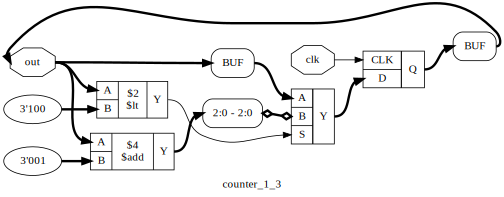

In [6]:
from examples.ys_aux import *

display(to_svg(design, "", 75))

### Exercise

1. Try guessing what the above elements do. You should be able to identify signals and values.
+  Which elements could be omitted for the raw functionality?

### Übung

1. Versuche, die Funktion der einzelnen Elemente in der Grafik intuitiv zu begreifen. Was sind Signale, was sind konstante Werte?
+  Welche Elemente könnten im Prinzip in der Grafik weggelassen werden?